# How to run PEEK on an Inference
## MNIST Demo

### Imports


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.special import entr

### MNIST - Data Loading

In [2]:
# Data preprocessing and loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Model - Convolutional Neural Network

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)  # --> returns 7 x 7
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

### Register Model Forward Hooks

These model forward hooks are registered on the convolutional layers only. They allow for passing of the convolutional feature maps to the ```compute_PEEK``` method. 

Here, the hooks have also been set to only activate when model is in evaluate or inference mode.


In [4]:
# Initialize model, loss function, and optimizer
model = SimpleCNN()

feature_maps = {}

def hook_fn(m, i, o):
        if not model.training:  # Ensures it only runs in eval mode
            print(f"Forward Hook (Inference Only) - {m.__class__.__name__}: Output Shape {o.shape}")
            feature_maps[m] = o # storing key-value pair in feature_maps dictionary
            # m --> (module) is the key
            # o --> (output) is the value

# Register hook to the model
model.conv1.register_forward_hook(hook_fn)
model.conv2.register_forward_hook(hook_fn)


### Create an Instance of Model

Create an instance of the model after the forward hooks have been registered. Otherwise the hooks will not initialize properly.

In [5]:

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train Model

In [6]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0807
Epoch [2/5], Loss: 0.0413
Epoch [3/5], Loss: 0.0130
Epoch [4/5], Loss: 0.0872
Epoch [5/5], Loss: 0.0478


### Set Model to Evaluate Mode

In [6]:
# set model to evaluate
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Run Inference on Test Image and Collect Feature Maps

Saves feature maps of test image in ```features``` directory

In [7]:
import torch
import os
import pickle

def save_feature_maps(model, feature_maps, test_dataset, device, save_path="./features/sample_image.pkl"):
    """
    Runs inference on the first test image and saves extracted feature maps.

    Args:
        model (torch.nn.Module): The trained model.
        test_dataset (Dataset): The dataset containing test images.
        device (torch.device): The device (CPU/GPU) to run inference on.
        save_path (str): Path to save the extracted feature maps.

    Returns:
        str: Path where the feature maps were saved.
    """

    # Select and preprocess the first test image
    sample_image, _ = test_dataset[0]
    sample_image = sample_image.unsqueeze(0).to(device)

    # Forward pass to capture feature maps
    with torch.no_grad():
        _ = model(sample_image)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save feature maps
    with open(save_path, "wb") as f:
        pickle.dump({layer: fmap.cpu().numpy() for layer, fmap in feature_maps.items()}, f)

    print(f"Feature maps saved at {save_path}")
    return save_path


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_map_path = save_feature_maps(model, feature_maps, test_dataset, device)

# Select a test image to run inference
sample_image, _ = test_dataset[0]  # Pick first image from test set
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension


Forward Hook (Inference Only) - Conv2d: Output Shape torch.Size([1, 16, 28, 28])
Forward Hook (Inference Only) - Conv2d: Output Shape torch.Size([1, 32, 14, 14])
Feature maps saved at ./features/sample_image.pkl


### Compute & Plot PEEK from Saved Feature Maps

In [15]:
# functions

# original PEEK function
def compute_PEEK(feature_maps, h, w):
    positivized_maps = feature_maps + np.abs(np.min(feature_maps))  # Make positive
    entropy_map = -np.sum(entr(positivized_maps), axis=-1)  # Compute entropy
    peek_map = cv2.resize(entropy_map, (w, h))  # Resize to match original image size
    return peek_map

# function for plotting PEEK maps
def plot_PEEK(modules, sample_image, feature_map_path):
    feature_map_path = feature_map_path if os.path.exists(feature_map_path) else None
    if feature_map_path is None:
        print(f"Feature map path {feature_map_path} does not exist. Please run save_feature_maps first.")

    # Load original image
    image = sample_image.squeeze().cpu().numpy()
    h, w = image.shape

    # Load feature maps
    with open(feature_map_path, 'rb') as f:
        loaded_feature_maps = pickle.load(f)

    # Plot for each convolutional layer
    fig, axes = plt.subplots(len(modules), 2, figsize=(8, 4 * len(modules)))

    for i, layer in enumerate(modules):
        # Original image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')

        # Compute and plot PEEK map
        # Get feature maps using layer as key
        feature_maps = loaded_feature_maps.get(layer, None)
        if feature_maps is None:
          # Find the key in loaded_feature_maps by comparing layer names
          for k in loaded_feature_maps.keys():
            if k.__class__.__name__ == layer.__class__.__name__ and str(k) == str(layer):
              feature_maps = loaded_feature_maps[k]
              break
          if feature_maps is None:
            raise KeyError(f"Layer {layer} not found in loaded_feature_maps")
        feature_maps = feature_maps[0] # Access the first element
        feature_maps = np.moveaxis(feature_maps, 0, -1)  # Rearrange channels
        peek_map = compute_PEEK(feature_maps, h, w)  # Compute PEEK map

        axes[i, 1].imshow(image, cmap='gray')  # Original image
        axes[i, 1].imshow(peek_map, alpha=0.7, cmap='jet')  # Overlay PEEK
        axes[i, 1].set_title(f'PEEK - {layer}')
        axes[i, 1].axis('off')

    fig.tight_layout()
    plt.show()

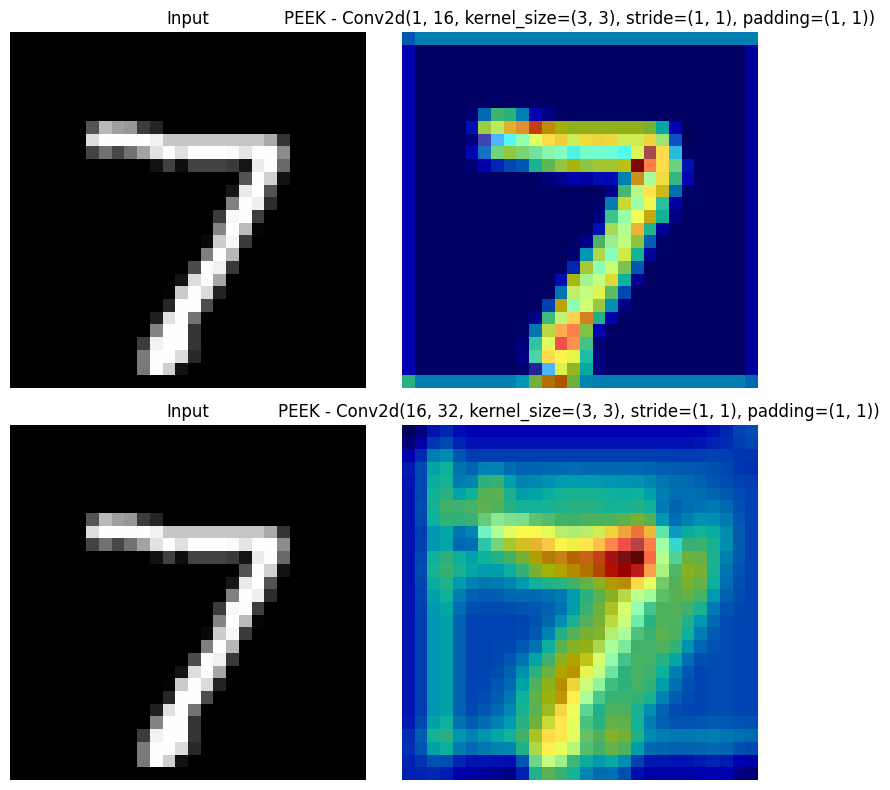

In [17]:
# Run PEEK visualization
plot_PEEK(modules=[model.conv1, model.conv2], sample_image=sample_image, feature_map_path=feature_map_path)